### degree -- home and work locations

In [51]:
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.gridspec as gridspec

import geopandas as gpd
import shapely
from shapely.geometry import Point,Polygon,LineString

import json
import time
from copy import deepcopy

### data prep -- geo_edgelist saved in the end

In [11]:
# follower network -- data
edgelist = pd.read_csv('../data/usageousers_city_follower_networks.rpt.gz')

# read in data about individuals -- data2
userinfo = pd.read_csv('../data/usageousers_data_export_with_tract_geoid_top50.csv.gz', index_col=0)
user_geo = userinfo.loc[:,["user_id", "lat_home", "lon_home", "lat_work", "lon_work"]]

In [12]:
# edgelist with geoinfo
edgelist = pd.merge(pd.merge(edgelist, user_geo, left_on="user_id1", right_on="user_id", how="left"),\
               user_geo, left_on="user_id2", right_on="user_id", how="left", suffixes=("1", "2"))

# remove duplicate columns
edgelist = edgelist.loc[:,~edgelist.columns.duplicated()]

In [13]:
# DISTANCE - home-home part

start_time = time.time()

# geometry cols
edgelist["geometry1"] = edgelist.apply(lambda r: Point(r["lon_home1"],r["lat_home1"]), axis=1)
edgelist["geometry2"] = edgelist.apply(lambda r: Point(r["lon_home2"],r["lat_home2"]), axis=1)

geo_edgelist = gpd.GeoDataFrame(edgelist)

# change crs
geo_edgelist = geo_edgelist.set_geometry('geometry2')
geo_edgelist.crs = {'init': 'epsg:4326'}
geo_edgelist = geo_edgelist.to_crs({'init': 'epsg:3857'})

geo_edgelist = geo_edgelist.set_geometry('geometry1')
geo_edgelist.crs = {'init': 'epsg:4326'}
geo_edgelist = geo_edgelist.to_crs({'init': 'epsg:3857'})

# set geometry
geo_edgelist = geo_edgelist.set_geometry('geometry1')

# home-home distance calculation
geo_edgelist['dist_hh'] = geo_edgelist['geometry1'].distance(geo_edgelist['geometry2'])

print("--- %s seconds ---" % (time.time() - start_time))

/usr/local/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


--- 390.20663619041443 seconds ---


In [5]:
# DISTANCE - work-work part

start_time = time.time()

# geometry cols
edgelist["geometry1"] = edgelist.apply(lambda r: Point(r["lon_work1"],r["lat_work1"]), axis=1)
edgelist["geometry2"] = edgelist.apply(lambda r: Point(r["lon_work2"],r["lat_work2"]), axis=1)

geo_edgelist2 = gpd.GeoDataFrame(edgelist)

# change crs
geo_edgelist2 = geo_edgelist2.set_geometry('geometry2')
geo_edgelist2.crs = {'init': 'epsg:4326'}
geo_edgelist2 = geo_edgelist2.to_crs({'init': 'epsg:3857'})

geo_edgelist2 = geo_edgelist2.set_geometry('geometry1')
geo_edgelist2.crs = {'init': 'epsg:4326'}
geo_edgelist2 = geo_edgelist2.to_crs({'init': 'epsg:3857'})

# set geometry
geo_edgelist2 = geo_edgelist2.set_geometry('geometry1')

# home-home distance calculation
geo_edgelist2['dist_ww'] = geo_edgelist2['geometry1'].distance(geo_edgelist2['geometry2'])

print("--- %s seconds ---" % (time.time() - start_time))

/usr/local/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


--- 428.23562598228455 seconds ---


In [18]:
# combine..
temp = geo_edgelist2.loc[:,["cbsacode", "user_id1", "user_id2", "dist_ww"]]
geo_edgelist = pd.merge(geo_edgelist, temp, on=["cbsacode", "user_id1", "user_id2"], how="left")

In [22]:
# at this point, save the data!!
export = geo_edgelist.drop(columns=['geometry1', 'geometry2'])
export.to_csv("../data/geo_edgelist_top50.csv.gz", compression="gzip", index=False)

### spatial distribution of ego networks

In [80]:
# data IN
geo_edgelist = pd.read_csv("../data/geo_edgelist_top50.csv.gz")

In [81]:
# bin distances
binsize=500

geo_edgelist["dh_bin"] = binsize*(geo_edgelist["dist_hh"]/binsize).map(int)+500
geo_edgelist["dw_bin"] = binsize*(geo_edgelist["dist_ww"]/binsize).map(int)+500

In [82]:
# degree table -- NOTE -- all ties are mutual
degree_tab = geo_edgelist.groupby("user_id1")["user_id2"].count().reset_index()
degree_tab.columns = ["user_id", "degree"]

In [83]:
# loop -- HOME
dh_table = degree_tab

for d in list(range(500, 10500, 500)):
    
    temp = geo_edgelist.loc[geo_edgelist.dh_bin == d,:].groupby("user_id1")["user_id2"].count().reset_index()
    temp.columns = ["user_id", ("dh"+str(d))]
    
    dh_table = pd.merge(dh_table, temp, on="user_id", how="left")

In [84]:
# loop -- WORK
dw_table = degree_tab

for d in list(range(500, 10500, 500)):
    
    temp = geo_edgelist.loc[geo_edgelist.dw_bin == d,:].groupby("user_id1")["user_id2"].count().reset_index()
    temp.columns = ["user_id", ("dw"+str(d))]
    
    dw_table = pd.merge(dw_table, temp, on="user_id", how="left")

In [85]:
# merge the resuls of the loops
d_table = pd.merge(dh_table, dw_table, on=["user_id", "degree"], how="left")

In [86]:
# remove users with less than 10 ties (!!!) AND replace NANs
d_table = d_table[d_table["degree"]>=10] 
d_table = d_table.fillna(0)

In [87]:
# get the share of each degree
for c in list(d_table.columns[2:,]):    
    d_table[str(c)+"_share"] = round((d_table[str(c)] / d_table["degree"]), 3)

In [88]:
# construct simple dataframe for plot
rownames = []
values = []
type1 = ["home"] * 20 + ["work"] * 20

for c in list(d_table.columns)[-40:]:
    rownames.append(str(c))
    values.append(np.mean(d_table[str(c)]))
    
frame = { 'dist': rownames , 'avg_degree_share': values, 'type': type1} 
result = pd.DataFrame(frame)

In [89]:
# cumulative shares -- percent of ties by distance
result["degree_share_cum"] = result.groupby("type")["avg_degree_share"].cumsum()

<ipython-input-16-b6f498d067bf>:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_xticklabels(labels)
<ipython-input-16-b6f498d067bf>:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(labels)


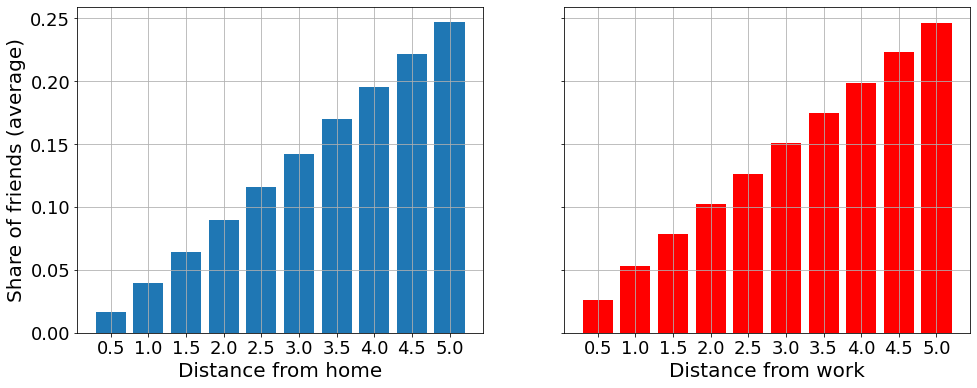

In [16]:
temp_home = result[result["type"]=="home"][:10]
temp_work = result[result["type"]=="work"][:10]

labels = list((np.linspace(0.5,5,10)))

plt.rcParams['font.size']=18
fig,ax = plt.subplots(1,2,figsize=(16,6), sharey=True)

ax[0].bar(temp_home["dist"], temp_home["degree_share_cum"])
ax[0].grid()
ax[0].set_xticklabels(labels)
ax[0].set_xlabel("Distance from home", size=20)
# ax[0].yaxis.set_major_formatter(mtick.PercentFormatter(1, decimals = 1)) 
ax[0].set_ylabel("Share of friends (average)", size=20)



ax[1].bar(temp_work["dist"], temp_work["degree_share_cum"], color="r")
ax[1].grid()
ax[1].set_xticklabels(labels)
ax[1].set_xlabel("Distance from work", size=20)

plt.show()

<ipython-input-49-6bdd6c37fb62>:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels)


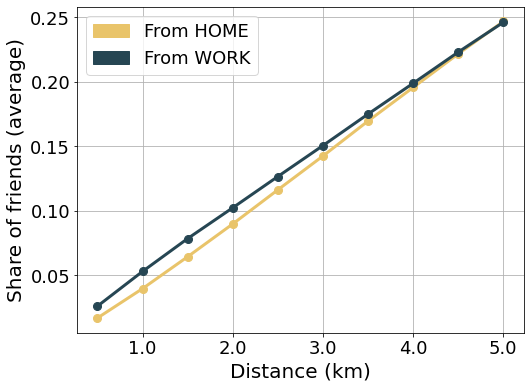

In [49]:
temp_home = result[result["type"]=="home"][:10]
temp_home["dist"] = list(range(500, 5500, 500))
temp_work = result[result["type"]=="work"][:10]
temp_work["dist"] = list(range(500, 5500, 500))

import matplotlib.patches as mpatches
plt.rcParams['font.size']=18
fig,ax = plt.subplots(1,1,figsize=(8,6), sharey=True)

labels = list((np.linspace(0,5,6)))

homep = ax.plot(temp_home["dist"], temp_home["degree_share_cum"], "o-", color="#e9c46a", linewidth=3, markersize=8)
workp = ax.plot(temp_work["dist"], temp_work["degree_share_cum"], "o-", color="#264653", linewidth=3, markersize=8)
ax.set_xticklabels(labels)

home_patch = mpatches.Patch(color='#e9c46a', label='From HOME')
work_patch = mpatches.Patch(color='#264653', label='From WORK')
ax.legend(handles=[home_patch, work_patch])

ax.set_xlabel("Distance (km)", size=20)
ax.set_ylabel("Share of friends (average)",  size=20)
ax.grid()
plt.show()

### futher issues
* home-work definitions + social netwoks (example) on MAP
* top50 metro areas average degree in 2km from H-W (similar to commuting)

### income and ego network distribution

In [3]:
# tract info
censusdata = pd.read_csv("../data/censusdata_top50_2012.csv")

# function to create tract geoids
def create_geoid(row):
    state = str(int(row["state"])).zfill(2)
    county = str(int(row["county"])).zfill(3)
    tract = str(int(row["tract"])).zfill(6)
    return "14000US" +state+county+tract

# geoid creation
censusdata['geoid'] = censusdata.apply(create_geoid,axis=1)

In [4]:
# userdata IN
userdata = pd.read_csv('../data/usageousers_data_export_with_tract_geoid_top50.csv.gz', index_col=0)

# remove bots
bot_flags = json.load(open("../data/bot_flags.json"))
userdata['drop'] = userdata['user_id'].map(int).map(str).map(bot_flags)
userdata = userdata[userdata['drop']==0]

In [5]:
## add cbsacodes to census tract level dataframe
temp = userdata.loc[:,['cbsacode', 'tract_home']].drop_duplicates()

# merge cbsacodes
census_df = pd.merge(censusdata, temp, left_on="geoid", right_on="tract_home", how="left")
census_df = census_df.drop(columns=("tract_home"))

# further filters
census_df = census_df[(census_df['income'] > 0)]

# remove NAs...
census_df = census_df.dropna()
census_df.shape

(38355, 23)

In [6]:
# get income percentiles by cbsacode
percentile = 25
census_df["income_lim1"] = census_df.cbsacode.map(census_df.groupby("cbsacode")['income']\
                                                  .quantile(percentile/100).to_dict())

census_df["income_lim2"] = census_df.cbsacode.map(census_df.groupby("cbsacode")['income']\
                                                  .quantile(1-percentile/100).to_dict())

In [7]:
# merging the user data and census data both on home and work census tracts
temp = pd.merge(userdata, census_df, left_on=["cbsacode", "tract_home"], right_on=["cbsacode", "geoid"], how="left")

# poor / rich dummies
po = (temp['income'] < temp["income_lim1"])
temp['poor'] = po.astype(int)

ri = (temp['income'] > temp["income_lim2"])
temp['rich'] = ri.astype(int)

# keep the necessary cols
temp = temp.loc[:,["user_id", "poor", "rich"]]

In [8]:
# data IN -- degree part
geo_edgelist = pd.read_csv("../data/geo_edgelist_top50.csv.gz")

In [9]:
# bin distances
binsize=500

geo_edgelist["dh_bin"] = binsize*(geo_edgelist["dist_hh"]/binsize).map(int)+500
geo_edgelist["dw_bin"] = binsize*(geo_edgelist["dist_ww"]/binsize).map(int)+500

In [10]:
# degree table -- NOTE -- all ties are mutual
degree_tab = geo_edgelist.groupby("user_id1")["user_id2"].count().reset_index()
degree_tab.columns = ["user_id", "degree"]

In [11]:
degree_tab = pd.merge(degree_tab, temp, on="user_id", how="inner")

In [12]:
# loop -- HOME
dh_table = degree_tab

for d in list(range(500, 10500, 500)):
    
    temp = geo_edgelist.loc[geo_edgelist.dh_bin == d,:].groupby("user_id1")["user_id2"].count().reset_index()
    temp.columns = ["user_id", ("dh"+str(d))]
    
    dh_table = pd.merge(dh_table, temp, on="user_id", how="left")

In [13]:
# loop -- WORK
dw_table = degree_tab

for d in list(range(500, 10500, 500)):
    
    temp = geo_edgelist.loc[geo_edgelist.dw_bin == d,:].groupby("user_id1")["user_id2"].count().reset_index()
    temp.columns = ["user_id", ("dw"+str(d))]
    
    dw_table = pd.merge(dw_table, temp, on="user_id", how="left")

In [14]:
# merge the resuls of the loops
dw_table = dw_table.drop(columns=["poor", "rich"])
d_table = pd.merge(dh_table, dw_table, on=["user_id", "degree"], how="left")

In [15]:
# remove users with less than 10 ties (!!!) AND replace NANs
d_table = d_table[d_table["degree"]>=10] 
d_table = d_table.fillna(0)
d_table.shape

(85077, 44)

In [16]:
# get the share of each degree
for c in list(d_table.columns[2:,]):    
    d_table[str(c)+"_share"] = round((d_table[str(c)] / d_table["degree"]), 3)

In [17]:
# poor users
d_poor = d_table[d_table["poor"]==1]

# rich users
d_rich = d_table[d_table["rich"]==1]

In [18]:
# construct simple dataframe for plot
rownames = []
values = []
type1 = ["home"] * 20 + ["work"] * 20

for c in list(d_poor.columns)[-40:]:
    rownames.append(str(c))
    values.append(np.mean(d_poor[str(c)]))
    
frame = { 'dist': rownames , 'avg_degree_share': values, 'type': type1} 
result_poor = pd.DataFrame(frame)

In [19]:
# construct simple dataframe for plot
rownames = []
values = []
type1 = ["home"] * 20 + ["work"] * 20

for c in list(d_rich.columns)[-40:]:
    rownames.append(str(c))
    values.append(np.mean(d_rich[str(c)]))
    
frame = { 'dist': rownames , 'avg_degree_share': values, 'type': type1} 
result_rich = pd.DataFrame(frame)

In [20]:
# cumulative shares -- percent of ties by distance
result_poor["degree_share_cum"] = result_poor.groupby("type")["avg_degree_share"].cumsum()
result_rich["degree_share_cum"] = result_rich.groupby("type")["avg_degree_share"].cumsum()

In [21]:
result_poor.head()

,dist,avg_degree_share,type,degree_share_cum
0,dh500_share,0.017972,home,0.017972
1,dh1000_share,0.026370,home,0.044342
2,dh1500_share,0.028594,home,0.072936
3,dh2000_share,0.029672,home,0.102608
4,dh2500_share,0.031345,home,0.133953


In [24]:
result_rich.tail()

,dist,avg_degree_share,type,degree_share_cum
35,dw8000_share,0.018255,work,0.390567
36,dw8500_share,0.018057,work,0.408625
37,dw9000_share,0.017149,work,0.425774
38,dw9500_share,0.015995,work,0.441769
39,dw10000_share,0.015225,work,0.456994


<ipython-input-32-fc4c552f9e99>:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0,0].set_xticklabels(labels)
<ipython-input-32-fc4c552f9e99>:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0,1].set_xticklabels(labels)
<ipython-input-32-fc4c552f9e99>:25: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1,0].set_xticklabels(labels)
<ipython-input-32-fc4c552f9e99>:31: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1,1].set_xticklabels(labels)


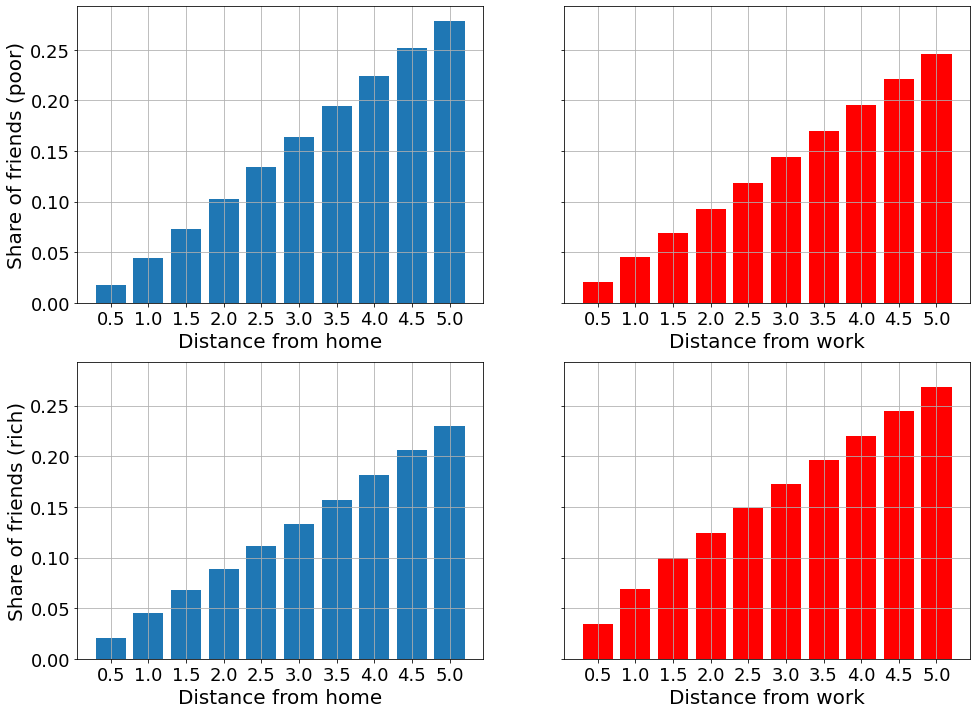

In [32]:
temp_home_poor = result_poor[result_poor["type"]=="home"][:10]
temp_work_poor = result_poor[result_poor["type"]=="work"][:10]

temp_home_rich = result_rich[result_rich["type"]=="home"][:10]
temp_work_rich = result_rich[result_rich["type"]=="work"][:10]

labels = list((np.linspace(0.5,5,10)))

plt.rcParams['font.size']=18
fig,ax = plt.subplots(2,2, figsize=(16,12), sharey=True)

ax[0,0].bar(temp_home_poor["dist"], temp_home_poor["degree_share_cum"])
ax[0,0].grid()
ax[0,0].set_xticklabels(labels)
ax[0,0].set_xlabel("Distance from home", size=20)
ax[0,0].set_ylabel("Share of friends (poor)", size=20)

ax[0,1].bar(temp_work_poor["dist"], temp_work_poor["degree_share_cum"], color="r")
ax[0,1].grid()
ax[0,1].set_xticklabels(labels)
ax[0,1].set_xlabel("Distance from work", size=20)

ax[1,0].bar(temp_home_rich["dist"], temp_home_rich["degree_share_cum"])
ax[1,0].grid()
ax[1,0].set_xticklabels(labels)
ax[1,0].set_xlabel("Distance from home", size=20)
ax[1,0].set_ylabel("Share of friends (rich)", size=20)

ax[1,1].bar(temp_work_rich["dist"], temp_work_rich["degree_share_cum"], color="r")
ax[1,1].grid()
ax[1,1].set_xticklabels(labels)
ax[1,1].set_xlabel("Distance from work", size=20)

plt.show()

<ipython-input-40-259c20d70460>:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels)


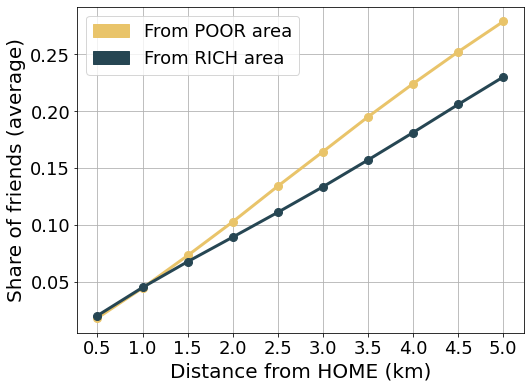

In [40]:
import matplotlib.patches as mpatches
plt.rcParams['font.size']=18
fig,ax = plt.subplots(1,1,figsize=(8,6), sharey=True)

labels = list((np.linspace(0.5,5,10)))

homep = ax.plot(temp_home_poor["dist"], temp_home_poor["degree_share_cum"], "o-", color="#e9c46a", linewidth=3, markersize=8)
workp = ax.plot(temp_home_rich["dist"], temp_home_rich["degree_share_cum"], "o-", color="#264653", linewidth=3, markersize=8)
ax.set_xticklabels(labels)

home_patch = mpatches.Patch(color='#e9c46a', label='From POOR area')
work_patch = mpatches.Patch(color='#264653', label='From RICH area')
ax.legend(handles=[home_patch, work_patch])

ax.set_xlabel("Distance from HOME (km)", size=20)
ax.set_ylabel("Share of friends (average)",  size=20)
ax.grid()
plt.show()

<ipython-input-41-6baf713b722b>:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels)


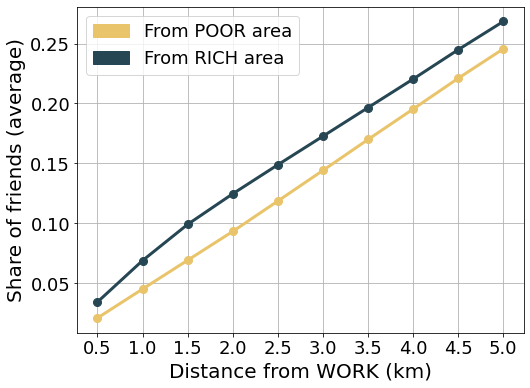

In [41]:
import matplotlib.patches as mpatches
plt.rcParams['font.size']=18
fig,ax = plt.subplots(1,1,figsize=(8,6), sharey=True)

labels = list((np.linspace(0.5,5,10)))

homep = ax.plot(temp_work_poor["dist"], temp_work_poor["degree_share_cum"], "o-", color="#e9c46a", linewidth=3, markersize=8)
workp = ax.plot(temp_work_rich["dist"], temp_work_rich["degree_share_cum"], "o-", color="#264653", linewidth=3, markersize=8)
ax.set_xticklabels(labels)

home_patch = mpatches.Patch(color='#e9c46a', label='From POOR area')
work_patch = mpatches.Patch(color='#264653', label='From RICH area')
ax.legend(handles=[home_patch, work_patch])

ax.set_xlabel("Distance from WORK (km)", size=20)
ax.set_ylabel("Share of friends (average)",  size=20)
ax.grid()
plt.show()

### gridspec combination

In [90]:
# last mile data prep

temp_home = result[result["type"]=="home"][:10]
temp_home["dist"] = list(range(500, 5500, 500))
temp_work = result[result["type"]=="work"][:10]
temp_work["dist"] = list(range(500, 5500, 500))

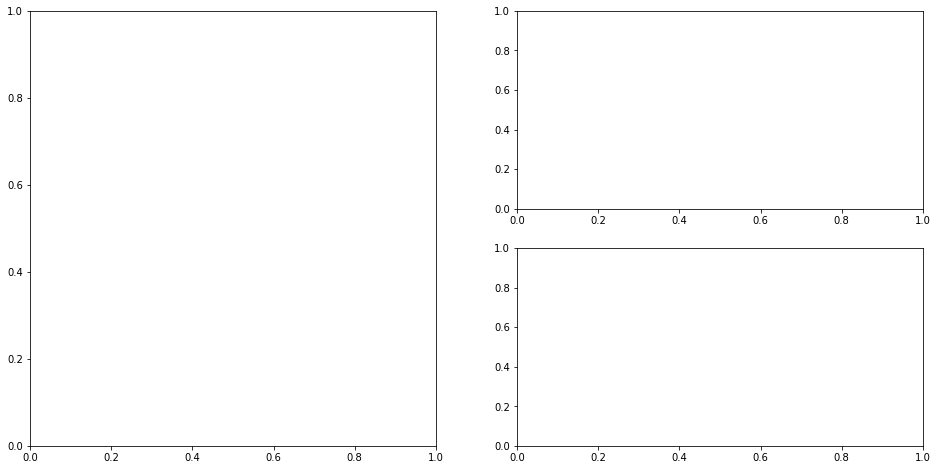

In [92]:
# combined figure
fig,ax = plt.subplots(2,2,figsize=(16,8))
gs = ax[0,0].get_gridspec()

ax[0,0].remove()
ax[1,0].remove()



axbig = fig.add_subplot(gs[0:2,0])



In [ ]:
# overlap POOR / RICH overlap of users in 5 kms from home / work
# distance of POOR / RICH distance distribution between home / work